# Projet 5 : Segmentez les comportements de clients
# <u>A. Analyse exploratoire des données</u> <br/>

# Le contexte

Notre employeur Datazon souhaite mieux comprendre le comportements de ses clients afin de faire de meilleures ventes et augmenter son chiffre d'affaire.

Notre **objectif** est de mieux comprendre les clients afin de les classer en catégories et de déterminer automatiquement la catégorie d'un client dès son premier achat.

Ce notebook traite de la partie exploratoire des données.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import  manifold, cluster
from IPython.display import display

%matplotlib inline

# 1. Préparation des données

## 1.1. Chargement des données

In [2]:
salesData = pd.read_excel("Online_Retail.xlsx")

In [3]:
# Nous faisons une copie des données pour faire notre analyse et nos traitements sans impacter les données d'origine.
df = salesData.copy()

## 1.2 Analyse rapide des données

### Taille de nos données

In [4]:
df.shape

(541909, 8)

Les données représentent 541 909 lignes et sont décrites par 8 variables

### Contenu

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

| Variable	    | Type  	                         | Description	                                          | 
|---------------|------------------------------------|--------------------------------------------------------|
| InvoiceNo     | Catégorielle. 6 digits         	 | Numéro de commande unique. commence par c = annulée    |
| StockCode     | Catégorielle. 5 digits             | Code unique identifiant le produit                     |
| Description   | Catégorielle. Text            	 | Description du produit                 	              |
| Quantity      | Continue. Nombre entier            | La quantité du produit commandée dans la transaction   |
| InvoiceDate   | Date / Heure (yyyy-mm-jj hh:mi:ss) | Jour et heure de la commande            	              |
| UnitPrice     | Continue. Nombre flottant          | Prix par unité en Livre Sterling                       |
| CustomerID    | Catégorielle. 5 digits        	 | Identifiant unique du client            	              |
| Country       | Catégorielle. Text           	     | Pays de résidence du client      	                  |


In [7]:
# On met la date dans le type datetime
df['InvoiceDate']=pd.to_datetime(salesData['InvoiceDate'])

## 1.3 Traitement des valeurs vides

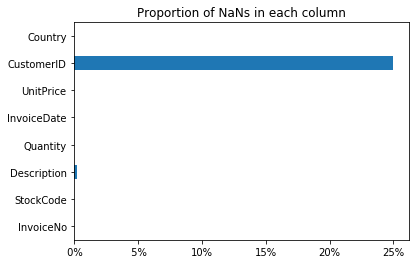

In [8]:
# affichage du nb de null pour chaque variable
ax =df.isnull().mean(axis=0).plot.barh()
vals = ax.get_xticks()
ax.set_xticklabels(['{:2.0f}%'.format(x*100) for x in vals])
plt.title("Proportion of NaNs in each column")

In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

- La base de données est plutôt complète.
- La colonne CustomerId est celle qui contient le plus de valeurs vides (1/4).25% non renseigné ce qui n'est pas négligeable
- On a quelques données manquantes au niveau de la colonne Description (à peine 0,3%)

### Traitement de la variable Description

Pour la variable description, on remplace les valeurs vides en récupérant la description d'une transaction avec le même code produit

In [10]:
stock_descriptions = df.dropna().groupby(['StockCode'])['Description'].last()
get_description=lambda x: stock_descriptions[x] if x in stock_descriptions else "No description"

mask=pd.isnull(df['Description'])
for index, row in df[mask].iterrows():
    df.loc[index,'Description']=get_description(row['StockCode'])

### Traitement de la variable CustomerID

In [11]:
df[df['CustomerID'].isnull()].sample(n=10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
445714,574856,23407,SET OF 2 TRAYS HOME SWEET HOME,1,2011-11-07 12:06:00,16.63,NaN,United Kingdom
253128,559162,21466,RED FLOWER CROCHET FOOD COVER,1,2011-07-06 16:29:00,3.29,NaN,United Kingdom
366169,568719,46776C,WOVEN FROST CUSHION COVER,2,2011-09-28 16:19:00,4.13,NaN,United Kingdom
415893,572550,22082,RIBBON REEL STRIPES DESIGN,2,2011-10-24 17:06:00,3.29,NaN,United Kingdom
167278,550986,85066,CREAM SWEETHEART MINI CHEST,2,2011-04-21 18:06:00,24.96,NaN,United Kingdom
272302,560772,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2011-07-20 16:12:00,3.29,NaN,United Kingdom
319125,564840,23308,SET OF 60 VINTAGE LEAF CAKE CASES,2,2011-08-30 12:49:00,1.25,NaN,United Kingdom
385050,570187,22754,SMALL RED BABUSHKA NOTEBOOK,2,2011-10-07 15:09:00,1.63,NaN,United Kingdom
22050,538149,84596e,SMALL LICORICE DES PINK BOWL,2,2010-12-09 16:27:00,2.51,NaN,United Kingdom
470762,576618,22554,PLASTERS IN TIN WOODLAND ANIMALS,1,2011-11-15 17:00:00,3.29,NaN,United Kingdom


Nous ne voyons pas de pattern particulier sur l'absence des données customerID. Il s'agit peut-être d'une anomalie de la plateforme ou il est peut-être possible de commander sans créer de compte ce qui parait peu probable.

Nous faisons le choix de supprimer les lignes pour lesquels l'identifiant client n'est pas rempli. Le client est la clé pour notre objectif. Il est donc préférable de ne supprimer les lignes dont l'identifiant client n'est pas rempli.

In [12]:
df=df.dropna()

In [13]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

=> Notre dataset ne contient plus de données vides.

## 1.4 Traitement des doublons

In [14]:
np.sum(df.duplicated())

5225

La base contient plus de 5000 doublons. On peut les supprimer.

In [15]:
df=df.drop_duplicates()

In [16]:
df.shape

(401604, 8)

=> Après traitement des données manquantes, notre dataset représente 401604 transactions.

## 1.5. Feature Engineering

- Création d'une variable stockant le prix total de la transaction. Pratique pour notre analyse.

In [17]:
df['TotalPrice'] = df['Quantity']*df['UnitPrice']

- Séparation des informations de date en colonne Mois, Année et Année-Mois

In [18]:
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['InvoiceMonth'] = df['InvoiceDate'].dt.month

In [19]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceYear,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12


# 2. Analyse des variables

In [22]:
"""Generic method to draw an histogram of the data given in parameter.
"""
def histogram(data, n_bins, cumulative=False, x_label = "", y_label = "", title = ""):
    _, ax = plt.subplots()
    ax.hist(data, bins = n_bins, cumulative = cumulative, color = '#539caf')
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
 
"""
Generic method to draw an bar graph of the data of the data given in parameter.
"""
def bar(data, x_label = "", y_label = "", title = "") :
    fig, ax = plt.subplots(figsize=(10,4))
    data.plot(kind='bar',color = '#539caf', align = 'center')
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

## 2.1 Les commandes

### Historique

In [23]:
print("min date: ", df['InvoiceDate'].min(), "->", df['InvoiceDate'].max())

min date:  2010-12-01 08:26:00 -> 2011-12-09 12:50:00


Nous avons un peu plus d'un an de données :<br/>- de **Décembre 2010 à Décembre 2011**.

### Clients, commandes et produits

In [25]:
pd.DataFrame([{'Customers': df['CustomerID'].nunique(),
               'Transactions': df['InvoiceNo'].nunique(),
               'Products': df['StockCode'].nunique(),     
              }], columns = ['Customers', 'Transactions', 'Products'], index = ['Quantity'])

,Customers,Transactions,Products
Quantity,4372,22190,3684


Notre base de données contient donc 
- 4372 clients
- Qui ont effectués plus de 22 000 transactions
- Qui ont achetés près de 3600 produits différents

### Chiffre d'affaire

In [26]:
sum(df['TotalPrice'])

8278519.4240034102

=> Plus de 8 millions de £ de chiffre d'affaire sur la période.

### Commandes annulées / Discount

Regardons plus en détails les commandes annulées.

In [27]:
n1 = len(df[df.InvoiceNo.str.startswith('C').notnull()].groupby('InvoiceNo').count())
n2=df['InvoiceNo'].nunique()
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 3654/22190 (16.47%) 


On peut noter que le nombre d'annulation est assez important (16%)

In [28]:
df[df.InvoiceNo.str.startswith('C').notnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceYear,InvoiceMonth
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50,2010,12
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65,2010,12
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80,2010,12
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,2010,12
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,2010,12


In [29]:
print('Number of canceled values', df[df.InvoiceNo.str.startswith('C').notnull()].shape[0])
print('Number of orders with negative quantity', df[df['Quantity'] < 0].shape[0])

Number of canceled values 8872
Number of orders with negative quantity 8872


 => Nous remarquons que toutes les commandes annulées ont des quantités négatives.<br/>
 => Les discount ont aussi des quantités négatives.

Créons 2 colonnes supplémentaires dans lesquels on indique si la commande est annulé ou pas et s'il s'agit d'un discount ou pas

In [30]:
df['Canceled']=df['Quantity'].apply(lambda q: 0 if q > 0 else 1)

In [31]:
df['Discount']=df['StockCode'].apply(lambda s: 1 if s == 'D' else 0)

In [32]:
df[df['Quantity']<0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceYear,InvoiceMonth,Canceled,Discount
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50,2010,12,1,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65,2010,12,1,0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80,2010,12,1,0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,2010,12,1,0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,2010,12,1,0


### Quantité

In [33]:
df['Quantity'].describe()

count    401604.000000
mean         12.183273
std         250.283037
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

=> La quantité moyenne de produit par commande est de 12 avec une médiane à 5. <br/>
=> Le max pour la quantité est particulièrement élevé : plus de 80 000 mais comme il s'agit de ventes à destination de revendeurs, on peut considérer que c'est normal.<br/>
=> On remarque la même valeur en négative pour le min (il s'agit d'annulations)

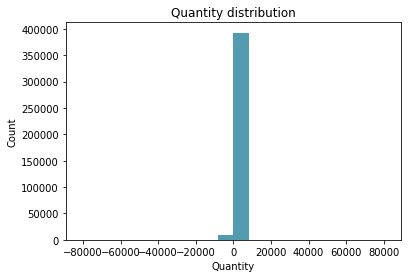

In [34]:
histogram(df['Quantity'], 20, x_label="Quantity", y_label = "Count", title = "Quantity distribution")

=> Nous avons essentiellement des quantités < 20 unités. Nous avons cependent une queue de distribution avec des valeurs plus importantes allant jusqu'à 80000 et -80 000 mais celà concerne peu de transactions.

### Prix unitaire

In [35]:
df['UnitPrice'].describe()

count    401604.000000
mean          3.474064
std          69.764035
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

=> Pour le prix unitaire, la moyenne de 3,4£ et la médiane à 1,95£. <br/>
=> Le max est à 38970£.

In [42]:
df[df.UnitPrice > 5000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceYear,InvoiceMonth,Canceled,Discount
173277,C551685,POST,POSTAGE,-1,2011-05-03 12:51:00,8142.75,16029.0,United Kingdom,-8142.75,2011,5,1,0
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,8142.75,2011,5,0,0
173391,C551699,M,Manual,-1,2011-05-03 14:12:00,6930.00,16029.0,United Kingdom,-6930.00,2011,5,1,0
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom,-38970.00,2011,6,1,0


=> Les produits avec tarif unitaire particulièrement élevé correspondent à des annulations de type frais de port ou manuel. Il s'agit peut-être d'erreurs qui ont été remboursées aux clients.

#### Distribution des variables

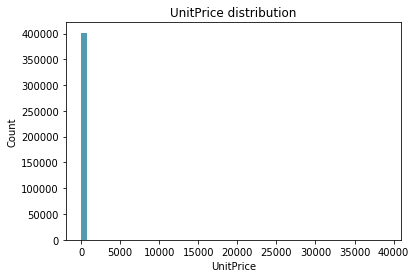

In [44]:
histogram(df['UnitPrice'], 50, x_label="UnitPrice", y_label = "Count", title = "UnitPrice distribution")

=> Nous avons essentiellement des prix unitaires < 10 £ mais également une fine queue de distribution avec des valeurs extrêmes allons jusqu'à 38 000£.<br/>
=> La valeur min est de 0.

In [45]:
df[df['UnitPrice'] == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceYear,InvoiceMonth,Canceled,Discount
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,0.0,2010,12,0,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,0.0,2010,12,0,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,0.0,2010,12,0,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0.0,2011,1,0,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0.0,2011,1,0,0


Les prix unitaires à 0 correspondent probablement à des promotions.<br/>
On rajoute une colonne pour indiquer si promotion ou pas car notre objectif est de catégoriser les clients en fonction de leur comportement.

In [46]:
df['Promotion']=df['UnitPrice'].apply(lambda p: 1 if p == 0 else 0)

In [48]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceYear,InvoiceMonth,Canceled,Discount,Promotion
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,0,0,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,0,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,0,0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,0,0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,0,0,0


## 2.2 Les pays

In [49]:
df.Country.nunique()

37

Nous avons des transactions pour 37 pays destinataires.

#### Voyons quels sont les nationalités de nos  acheteurs.

In [50]:
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

=> Nous avons des clients de presque tous les continents : Europe, Asie, Amérique et Afrique (RSA).

#### Regardons le nombre d'achat par pays

In [51]:
gp_country = df.groupby('Country')

In [52]:
orders_country = gp_country['InvoiceNo'].unique().agg(np.size).sort_values(ascending=False)

Country
United Kingdom          19857
Germany                   603
France                    458
EIRE                      319
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                71
Portugal                   70
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan                      28
Poland                     24
Denmark                    21
Cyprus                     20
Austria                    19
Singapore                  10
Malta                      10
Unspecified                 8
USA                         7
Iceland                     7
Greece                      6
Canada                      6
Israel                      6
European Community          5
Czech Republic              5
Lithuania                   4
United Arab Emirates        3
Saudi Arabia                2
Ba

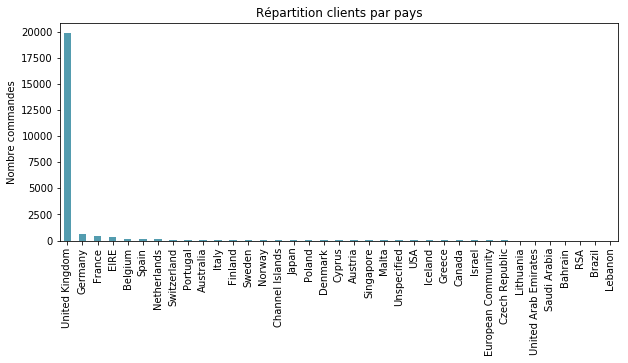

In [53]:
bar(orders_country, "", "Nombre commandes", "Répartition clients par pays")
orders_country

Nous avons essentiellement des transactions à destination des clients UK. La très grande majorité de nos clients sont des Anglais.<br/>
On a des quantités négligeables pour certains pays (Brésil, Canada, Grece, ...).<br/>

Nous allons distinguer les acheteurs Anglais du reste du monde en rajoutant une colonne supplémentaire.

In [54]:
df['UK']=df['Country'].apply(lambda c: 1 if c == "United Kingdom" else 0)

In [55]:
display(df.head())
df.shape

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceYear,InvoiceMonth,Canceled,Discount,Promotion,UK
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,0,0,0,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,0,0,0,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,0,0,0,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,0,0,0,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,0,0,0,1


(401604, 15)

## 2.3 les produits

Observons maintenant les produits

In [56]:
df['StockCode'].nunique()

3684

Nous avons plus de 3600 références de produits

### Produits les plus vendus

In [57]:
gp_stockcode = df.groupby('Description')
gp_stockcode_frq_quantitiy = gp_stockcode['Quantity'].agg(np.sum).sort_values(ascending=False)

Volume total :  4892851
% des 20 meilleurs produits : 11%


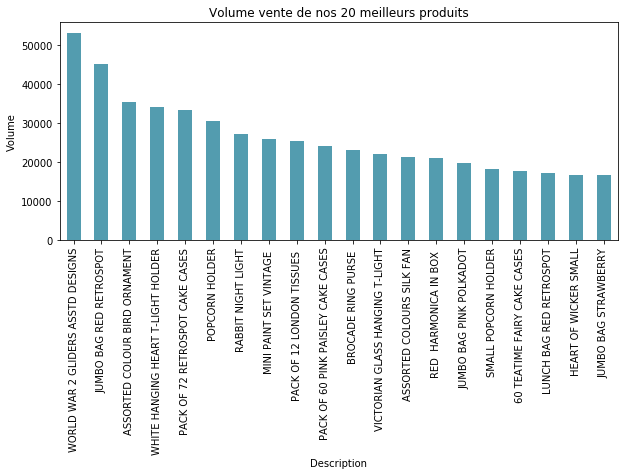

In [65]:
bar(gp_stockcode_frq_quantitiy.head(20), "Description", "Volume", "Volume vente de nos 20 meilleurs produits")
print("Volume total : ", gp_stockcode_frq_quantitiy.sum())
print("% des 20 meilleurs produits : {:2.0f}%".format(gp_stockcode_frq_quantitiy.head(20).sum()/gp_stockcode_frq_quantitiy.sum()*100))

=> On peut dire qu'on a 2  produits particulièrement vendus :
- World War 2 gliders
- Jumbo baf red

=> Les 20 meilleurs produits (0,5% des produits) représentent 11% de nos ventes.


### Produits avec code spécial

In [66]:
special_codes=df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True, na=False)]['StockCode'].unique()
for c in special_codes :
    print(c, '->', df[df['StockCode'] == c]['Description'].unique())

POST -> ['POSTAGE']
D -> ['Discount']
C2 -> ['CARRIAGE']
M -> ['Manual']
BANK CHARGES -> ['Bank Charges']
PADS -> ['PADS TO MATCH ALL CUSHIONS']
DOT -> ['DOTCOM POSTAGE']
CRUK -> ['CRUK Commission']


Nous remarquons que ce sont des transactions liées à des frais de ports, transports, ...
Nous nous intéressons surtout aux clients et à leurs achats, nous faisons donc le choix de les supprimer de nos données. Nous gardons juste les transactions de type Discount.

In [67]:
mask = df['StockCode'].isin(special_codes) & (df['StockCode'] != 'D')
df = df[~mask].copy()

### Classement pas types de produits

On classe les produits en 4 catégories de prix selon les quartiles ([0-25%], [25%-50%], [50%-75%], [75%-100%])

In [68]:
def score(x, quantiles) :
    if x <= quantiles[0.25] :
        return 1
    elif x <= quantiles[0.5] :
        return 2
    elif x <= quantiles[0.75] :
        return 3
    else :
        return 4

In [69]:
quantiles = df['UnitPrice'].quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

On créé une colonne dans laquelle on indique la catégorie du produit en terme de tarif (faible, moyen, élevé, très élevé)

df['ProductCategory'] = df['UnitPrice'].apply(score, args=(quantiles,))

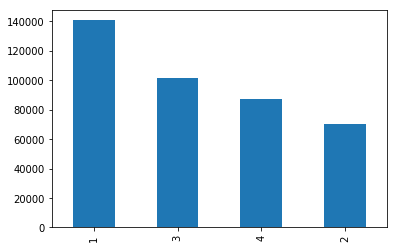

In [71]:
df['ProductCategory'].value_counts().plot(kind='bar')

On a une majorité de produits à faible prix mais les autres niveaux restent équilibrés et les produits les plus chers ne sont pas les moins vendus.

## 2.4 Les clients

In [74]:
gp_customer = df.groupby('CustomerID')

### Nos meilleurs clients (par montant total dépensé)

In [75]:
customers_amounts = gp_customer['TotalPrice'].agg(np.sum).sort_values(ascending=False)
customers_amounts.head(20)

CustomerID
14646.0    278571.62
18102.0    259657.30
17450.0    189490.73
14911.0    128333.73
12415.0    123638.18
14156.0    113685.77
17511.0     88138.20
16684.0     65892.08
13694.0     62714.54
16029.0     60177.89
15311.0     59284.19
13089.0     57322.13
15061.0     54250.34
14096.0     53258.43
17949.0     53215.74
15769.0     51823.72
14298.0     50862.44
14088.0     50415.49
17841.0     39861.49
15098.0     39619.50
Name: TotalPrice, dtype: float64

In [82]:
print("% CA des 20 meilleurs client :{:2.0f}%".format(customers_amounts.head(20).sum() / df.TotalPrice.sum() *100))

% CA des 20 meilleurs client :23%


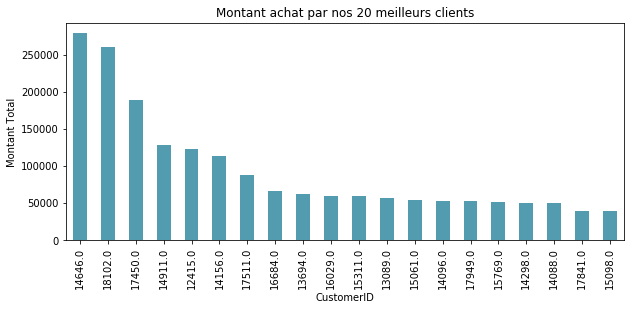

In [76]:
bar(customers_amounts.head(20), "CustomerID", "Montant Total", "Montant achat par nos 20 meilleurs clients")

**Nos 20 meilleurs clients (0,5% des clients) nous rapportent plus de 20% de notre CA !**

### Panier moyen par client

In [83]:
shopping_cart = df.groupby([ "CustomerID", "InvoiceNo"], as_index=False)['TotalPrice'].sum()
display(shopping_cart.head())
print("Panier moyen par client : {:.2f}£".format(shopping_cart['TotalPrice'].mean()))

,CustomerID,InvoiceNo,TotalPrice
0,12346.0,541431,77183.60
1,12346.0,C541433,-77183.60
2,12347.0,537626,711.79
3,12347.0,542237,475.39
4,12347.0,549222,636.25


Panier moyen par client : 377.97£


### Repartition des montants d'achats des clients

In [84]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 10000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = shopping_cart[(shopping_cart['TotalPrice'] < price) &
                       (shopping_cart['TotalPrice'] > price_range[i-1])]['TotalPrice'].count()
    count_price.append(val)
count_price

[1087, 1061, 4004, 8140, 2837, 1146, 73]

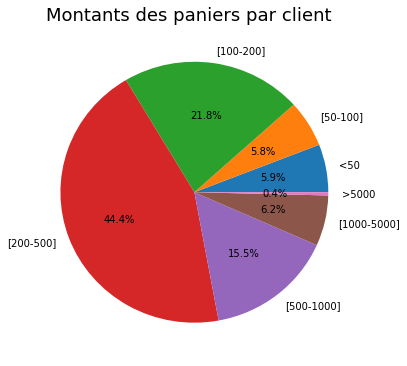

In [85]:
f, ax = plt.subplots(figsize=(6, 6))
labels = '<50', '[50-100]', '[100-200]', '[200-500]', '[500-1000]', '[1000-5000]', '>5000'
fracs = [1087, 1061, 4004, 8140, 2836, 1146, 73]
plt.pie(fracs, labels=labels, autopct='%1.1f%%', shadow=False)
f.text(0.5, 0.9, "Montants des paniers par client", ha='center', fontsize = 18);

**La majorité des clients (65%) ont un panier moyen compris entre 100 et 500 £.**

## 2.5 Analyse par période

### Nombre de ventes par mois

In [86]:
gp_month = df.sort_values('InvoiceDate').groupby(['InvoiceYear', 'InvoiceMonth'])

In [87]:
# Répartition des factures par mois
gp_month_invoices = gp_month['InvoiceNo'].unique().agg(np.size)
gp_month_invoices

InvoiceYear  InvoiceMonth
2010         12              1698
2011         1               1226
             2               1185
             3               1593
             4               1361
             5               1815
             6               1693
             7               1560
             8               1514
             9               2044
             10              2210
             11              3041
             12               913
Name: InvoiceNo, dtype: int64

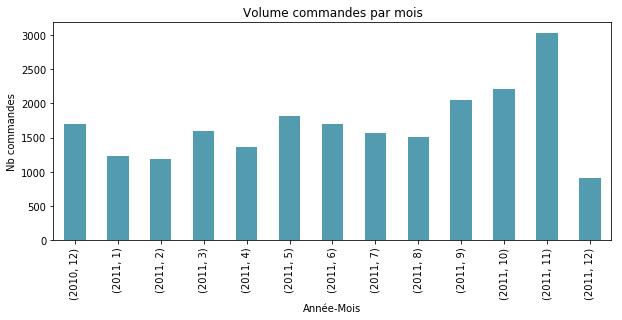

In [88]:
bar(gp_month_invoices, "Année-Mois", "Nb commandes", "Volume commandes par mois")

In [89]:
gp_month_invoices.describe()

count      13.000000
mean     1681.000000
std       538.140161
min       913.000000
25%      1361.000000
50%      1593.000000
75%      1815.000000
max      3041.000000
Name: InvoiceNo, dtype: float64

- Nous constatons que Novembre 2011 représente le meilleur mois des ventes en terme d'actes.
- Le mois de Décembre 2011 ne comprend pas un mois complet mais uniquement 9 jours. On peut supposer qu'en Décembre, on va atteindre les volumes des commandes de Novembre.
- Les ventes sont à peu près équilibrées sur les autres mois avec une hause à partir de Septembre correspondant à la hausse des ventes de fin d'année.

### Chiffre d'affaire par mois

In [90]:
gp_month_frq_amount= gp_month['TotalPrice'].agg(np.sum)
gp_month_frq_amount

InvoiceYear  InvoiceMonth
2010         12               547199.94
2011         1                471407.37
             2                433733.18
             3                572913.84
             4                419128.15
             5                650219.82
             6                640316.73
             7                580050.70
             8                611592.09
             9                921481.87
             10               960986.41
             11              1112627.27
             12               338123.34
Name: TotalPrice, dtype: float64

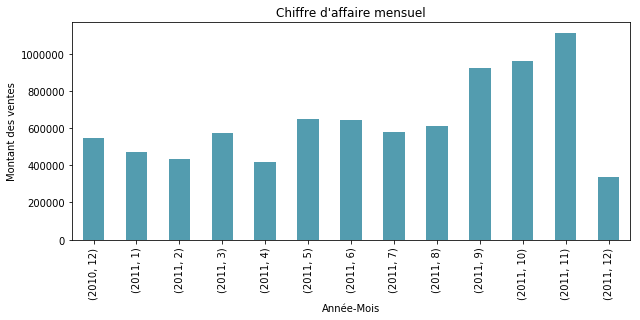

In [91]:
bar(gp_month_frq_amount, "Année-Mois", "Montant des ventes", "Chiffre d'affaire mensuel")

- Nous retrouvons le même type de répartition que pour le nombre de transactions
- Augmentation des ventes en fin d'année à partir de Septembre.

## 2.6 Correlation des variables.

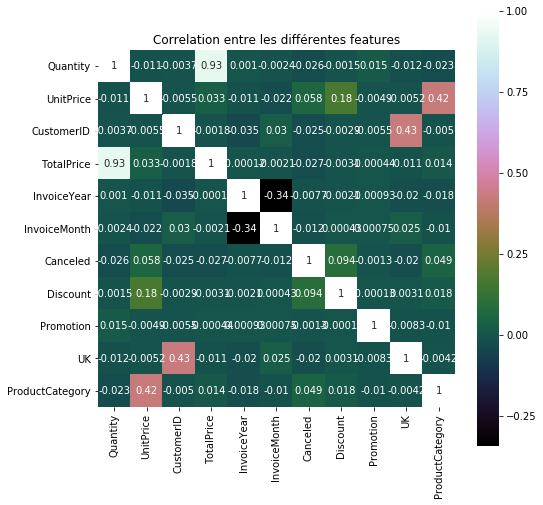

In [93]:
correlation = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation entre les différentes features')

- Les correlations que nous observons est entre Prix Total et Quantité  et entre product category et unit price ce qui totalement logique 
- Sinon pas vraiment d'autres corrélations significatives entre les autres variables.

# Sauvegarde du dataframe

On sauve les données pour faire le traitement pour déterminer les segments.

In [94]:
df.to_csv('orders.csv', index=False)